# Generating relevent visuals for the Write up

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mmm_param_recovery.benchmarking import storage, data_loader, evaluation

2025-09-01 09:28:20.886355: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756718900.911363 1764967 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756718900.919684 1764967 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/envs/python312-cpu/lib/python3.12/site-packages/pymc_marketing/mmm/multidimensional.py:72: FutureWarning: This functionality is experimental and subject to change. If you encounter any issues or have suggestions, please raise them at: https://github.com/pymc-labs/pymc-marketing/issues/new
  warnings.warn(warning_msg, FutureWarning, stacklevel=1)


In [8]:
dataset_name = "small_business"
seed = 2148
channel = "x3_Local-Ads"
channel_idx = 2

# Load data
print("Loading data...")
datasets = data_loader.load_multiple_datasets([dataset_name], seed)
data_df, channel_columns, control_columns, truth_df = datasets[0]

# Extract ground truth contributions
truth_local = truth_df[truth_df['geo'] == 'Local'].copy()
true_col = f"contribution_{channel}"
true_contrib = truth_local[true_col].values

# Get dates for x-axis
dates = pd.to_datetime(truth_local['time'].values)

# Get spend data
spend = data_df[data_df['geo'] == 'Local'][channel].values

Loading data...


╭─────────────────────────────────╮
│ Loading dataset: small_business │
╰─────────────────────────────────╯

Loading existing data for small_business

 Dataset shape             104 rows × 12 columns                                             
  Effective modeling size   104 rows × 9 columns (time, geo, 4 channels, 2 controls, target)  
  Regions                   ['Local']                                                         
  Date range                2020-01-05 00:00:00 to 2021-12-26 00:00:00                        
  Channels                  4 channels: x1_Search-Ads, x2_Social-Media, x3_Local-Ads...       
  Controls                  2 controls

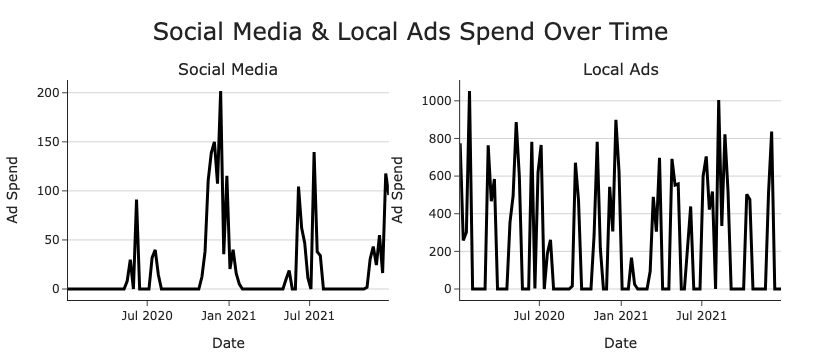

In [143]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Filter to only geo = Local
df_local = data_df[data_df['geo'] == 'Local']

# Ensure time column is datetime
df_local['time'] = pd.to_datetime(df_local['time'])

# Create subplot layout with 1 row, 2 columns
fig = make_subplots(
    rows=1, cols=2, 
    subplot_titles=("Social Media", "Local Ads")
)

# Add Social Media trace (left)
fig.add_trace(go.Scatter(
    x=df_local['time'], 
    y=df_local['x2_Social-Media'],
    mode='lines',
    name='Social Media',
    line=dict(color='black', width=3),
    marker=dict(size=6, color='black')
), row=1, col=1)

# Add Local Ads trace (right)
fig.add_trace(go.Scatter(
    x=df_local['time'], 
    y=df_local['x3_Local-Ads'],
    mode='lines',
    name='Local Ads',
    line=dict(color='black', width=3),
    marker=dict(size=6, color='black')
), row=1, col=2)

# Update layout for aesthetics
fig.update_layout(
    template='simple_white',
    title=dict(text='Social Media & Local Ads Spend Over Time', x=0.5, font=dict(size=24)),
    xaxis=dict(title='Date', showgrid=False, zeroline=False),
    xaxis2=dict(title='Date', showgrid=False, zeroline=False),
    yaxis=dict(title='Ad Spend', showgrid=True, gridcolor='lightgrey'),
    yaxis2=dict(title='Ad Spend', showgrid=True, gridcolor='lightgrey'),
    #legend=dict(title='', orientation='h', yanchor='bottom', y=1.02, xanchor='center', x=0.5),
    showlegend=False,
    plot_bgcolor='white',
    margin=dict(l=40, r=40, t=80, b=40)
)

# Show figure
fig.show()

# Save figure as HTML
fig.write_html("social_media_local_ads.html")


In [9]:
print("Loading Meridian model...")
# Load and extract Meridian contributions
meridian_model, _, _ = storage.load_meridian_model(dataset_name)

print("Loading PyMC-Marketing (nutpie) model...")
# Load and extract PyMC contributions
pymc_model, _, _ = storage.load_pymc_model(dataset_name, "nutpie")

Loading Meridian model...


2025-09-01 09:55:23.593209: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


  ✓ Loaded Meridian from cache (169.6s)
Loading PyMC-Marketing (nutpie) model...
  ✓ Loaded PyMC-Marketing - nutpie from cache (136.8s)


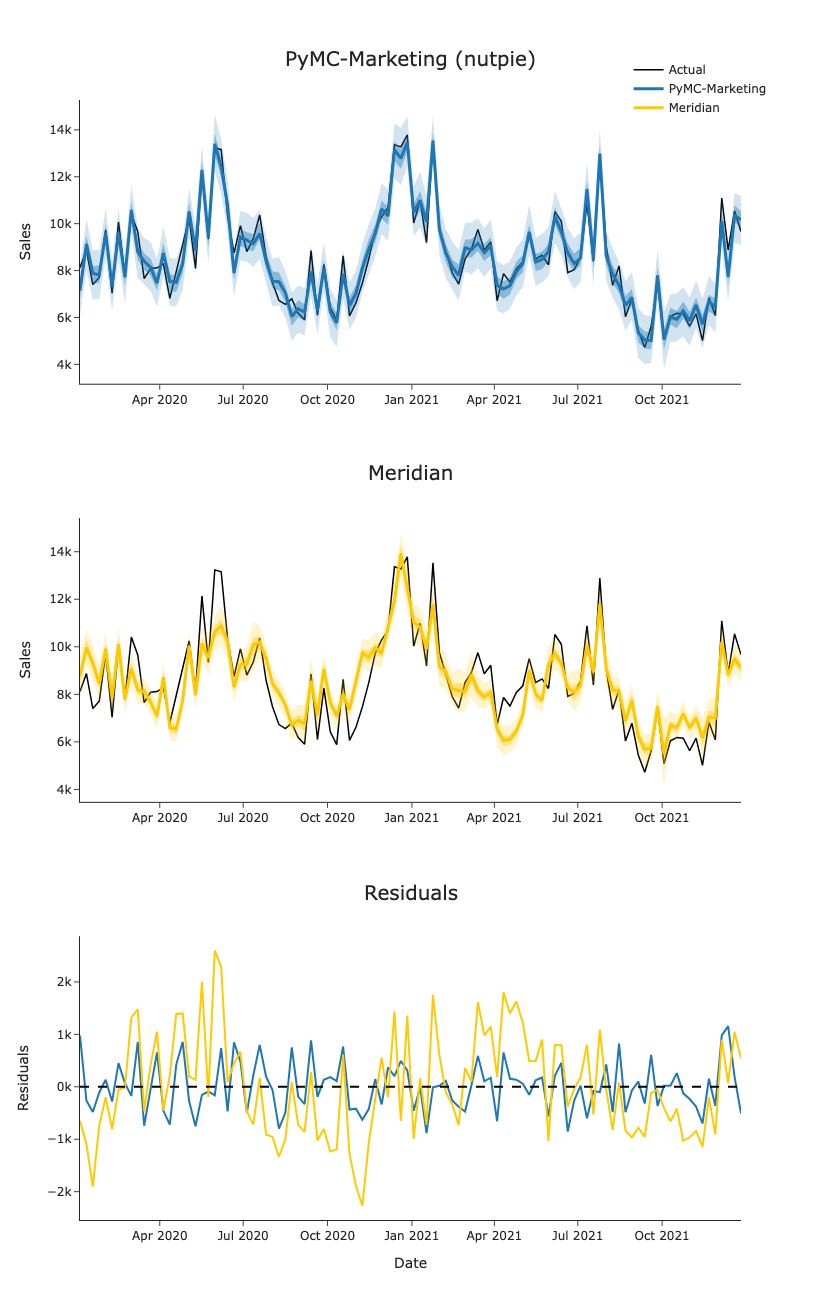

In [147]:
# Colors
pymc_blue = 'rgb(31,119,180)'   # PyMC blue
google_yellow = 'rgb(255,202,0)'  # Google yellow

# ------------------ Combined Figure: PyMC, Meridian, Residuals ------------------
fig = make_subplots(
    rows=3, cols=len(geos),
    #subplot_titles=[f"{geo}" for geo in geos]*3,
    shared_yaxes=True,
    vertical_spacing=0.12,
    horizontal_spacing=0.05
)

# ------------------ PyMC-Marketing Top Row ------------------
for j, geo in enumerate(geos):
    y_pred = y_pp.sel(geo=geo)
    sample_dims = ['chain','draw']

    hdi_94 = az.hdi(y_pred, hdi_prob=0.94)
    hdi_50 = az.hdi(y_pred, hdi_prob=0.5)
    median_pred = y_pred.median(dim=sample_dims)

    hdi_94_lower = hdi_94['y_original_scale'].sel(hdi='lower').to_numpy()
    hdi_94_upper = hdi_94['y_original_scale'].sel(hdi='higher').to_numpy()
    hdi_50_lower = hdi_50['y_original_scale'].sel(hdi='lower').to_numpy()
    hdi_50_upper = hdi_50['y_original_scale'].sel(hdi='higher').to_numpy()
    median_vals = median_pred.to_numpy()

    x_vals = pd.to_datetime(dates)

    # Actual
    geo_data = data_df.query("geo == @geo").sort_values("time")
    fig.add_trace(go.Scatter(
        x=x_vals, y=geo_data["y"].values,
        mode='lines',
        line=dict(color='black', width=1.5),
        name='Actual' if j==0 else None,
        showlegend=(j==0)
    ), row=1, col=j+1)

    # Median
    fig.add_trace(go.Scatter(
        x=x_vals, y=median_vals,
        mode='lines',
        line=dict(color=pymc_blue, width=3),
        name='PyMC-Marketing' if j==0 else None,
        showlegend=(j==0)
    ), row=1, col=j+1)

    # HDI 94%
    fig.add_trace(go.Scatter(
        x=x_vals, y=hdi_94_lower,
        mode='lines', line=dict(width=0),
        name='94% HDI' if j==0 else None,
        showlegend=False
    ), row=1, col=j+1)
    fig.add_trace(go.Scatter(
        x=x_vals, y=hdi_94_upper,
        mode='lines', fill='tonexty',
        fillcolor='rgba(31,119,180,0.2)',
        line=dict(width=0),
        showlegend=False
    ), row=1, col=j+1)

    # HDI 50%
    fig.add_trace(go.Scatter(
        x=x_vals, y=hdi_50_lower,
        mode='lines', line=dict(width=0),
        name='50% HDI' if j==0 else None,
        showlegend=False
    ), row=1, col=j+1)
    fig.add_trace(go.Scatter(
        x=x_vals, y=hdi_50_upper,
        mode='lines', fill='tonexty',
        fillcolor='rgba(31,119,180,0.4)',
        line=dict(width=0),
        showlegend=False
    ), row=1, col=j+1)

# ------------------ Meridian Middle Row ------------------
for j, geo in enumerate(geos):
    geo_data = data_df[data_df["geo"] == geo].copy().sort_values("time")
    geo_predictions = predictions[:, j, :]
    n_times_data = len(geo_data)
    if n_times_pred != n_times_data:
        n_times_use = min(n_times_pred, n_times_data)
        geo_predictions = geo_predictions[:, :n_times_use]
        geo_data = geo_data.iloc[:n_times_use]

    hdi_94 = np.array([az.hdi(geo_predictions[:, t], hdi_prob=0.94) for t in range(len(geo_data))])
    hdi_50 = np.array([az.hdi(geo_predictions[:, t], hdi_prob=0.50) for t in range(len(geo_data))])
    median_pred_vals = np.median(geo_predictions, axis=0)

    x_vals = pd.to_datetime(geo_data["time"])

    # Actual
    fig.add_trace(go.Scatter(
        x=x_vals, y=geo_data["y"].values,
        mode='lines',
        line=dict(color='black', width=1.5),
        name='Actual' if j==0 else None,
        showlegend=False
    ), row=2, col=j+1)

    # Median
    fig.add_trace(go.Scatter(
        x=x_vals, y=median_pred_vals,
        mode='lines',
        line=dict(color=google_yellow, width=3),
        name='Meridian' if j==0 else None,
        showlegend=(j==0)
    ), row=2, col=j+1)

    # HDI 94%
    fig.add_trace(go.Scatter(
        x=x_vals, y=hdi_94[:,0],
        mode='lines', line=dict(width=0),
        name='94% HDI' if j==0 else None,
        showlegend=False
    ), row=2, col=j+1)
    fig.add_trace(go.Scatter(
        x=x_vals, y=hdi_94[:,1],
        mode='lines', fill='tonexty',
        fillcolor='rgba(255,202,0,0.2)',
        line=dict(width=0),
        showlegend=False
    ), row=2, col=j+1)

    # HDI 50%
    fig.add_trace(go.Scatter(
        x=x_vals, y=hdi_50[:,0],
        mode='lines', line=dict(width=0),
        name='50% HDI' if j==0 else None,
        showlegend=False
    ), row=2, col=j+1)
    fig.add_trace(go.Scatter(
        x=x_vals, y=hdi_50[:,1],
        mode='lines', fill='tonexty',
        fillcolor='rgba(255,202,0,0.4)',
        line=dict(width=0),
        showlegend=False
    ), row=2, col=j+1)

# ------------------ Residuals Bottom Row ------------------
for j, geo in enumerate(geos):
    geo_data = data_df[data_df["geo"] == geo].copy().sort_values("time")
    x_vals = pd.to_datetime(geo_data["time"])

    # PyMC residuals
    y_pred_pymc = y_pp.sel(geo=geo).median(dim=['chain','draw']).to_numpy()
    residuals_pymc = geo_data["y"].values - y_pred_pymc
    
    residuals_pymc_scaled = residuals_pymc / 1000
    residuals_meridian_scaled = residuals_meridian / 1000

    # Meridian residuals
    geo_predictions = predictions[:, j, :]
    if n_times_pred != len(geo_data):
        n_times_use = min(n_times_pred, len(geo_data))
        geo_predictions = geo_predictions[:, :n_times_use]
        geo_data_sub = geo_data.iloc[:n_times_use]
        x_vals = pd.to_datetime(geo_data_sub["time"])
        y_actual = geo_data_sub["y"].values
    else:
        y_actual = geo_data["y"].values
    residuals_meridian = y_actual - np.median(geo_predictions, axis=0)

    # PyMC residuals
    fig.add_trace(go.Scatter(
        x=x_vals.values, y=residuals_pymc_scaled,
        mode='lines',
        line=dict(color=pymc_blue, width=2),
        name='PyMC-Marketing Residuals' if j==0 else None,
        showlegend= False
    ), row=3, col=j+1)

    # Meridian residuals
    fig.add_trace(go.Scatter(
        x=x_vals.values, y=residuals_meridian_scaled,
        mode='lines',
        line=dict(color=google_yellow, width=2),
        name='Meridian Residuals' if j==0 else None,
        showlegend = False
    ), row=3, col=j+1)
    
    # Zero line
    fig.add_trace(go.Scatter(
        x=x_vals,  # keep as pandas datetime
        y=np.zeros(len(x_vals)),
        mode='lines',
        line=dict(color='black', width=2, dash='dash'),
        name='0',
        showlegend= False
    ), row=3, col=j+1)
    
    fig.update_yaxes(type="linear", row=3, col=j+1)

# ------------------ Layout ------------------
fig.update_layout(
    height=1300,
    width=1000*len(geos),
    template='simple_white',
    legend=dict(
        x=0.83, y=1.04, traceorder='normal',
        font=dict(size=12), bgcolor="rgba(255,255,255,0.5)"
    )
)

# Row titles
fig.add_annotation(x=0.5, y=1.05, xref='paper', yref='paper',
                   text="PyMC-Marketing (nutpie)", showarrow=False,
                   font=dict(size=20), xanchor='center')
fig.add_annotation(x=0.5, y=0.68, xref='paper', yref='paper',
                   text="Meridian", showarrow=False,
                   font=dict(size=20), xanchor='center')
fig.add_annotation(x=0.5, y=0.28, xref='paper', yref='paper',
                   text="Residuals", showarrow=False,
                   font=dict(size=20), xanchor='center')

# X and Y labels
fig.update_xaxes(title_text="Date", row=3, col=1)
fig.update_yaxes(title_text="Sales", row=1, col=1)
fig.update_yaxes(title_text="Sales", row=2, col=1)
fig.update_yaxes(title_text="Residuals", row=3, col=1)
fig.update_yaxes(title_text="Residuals", row=3, col=1, tickformat=",", ticksuffix="k")

fig.show()

# Save figure as HTML
fig.write_html("actual_vs_predicted.html")


In [229]:
pymc_contributions = pymc_model.idata.posterior['channel_contribution_original_scale'].sel(geo = 'Local').sel(channel = ['x2_Social-Media', 'x4_Email'])

In [228]:
truth = truth_local[['time', 'contribution_x2_Social-Media', 'contribution_x4_Email']]

In [230]:
import xarray as xr
import tensorflow as tf

model_analysis = analyzer.Analyzer(meridian_model)

incremental_df = model_analysis.incremental_outcome(
    aggregate_times=False,
    aggregate_geos=False,
    use_kpi=True,
)

# Suppose your tensor is called `tensor`
arr = incremental_df.numpy()  # convert to NumPy

# Define dimension names
dims = ["chain", "draw", "geo", "time", "channel"]

# Optionally, define coordinates
coords = {
    "chain": range(arr.shape[0]),
    "draw": range(arr.shape[1]),
    "geo": range(arr.shape[2]),
    "time": range(arr.shape[3]),
    "channel": range(arr.shape[4])
}

# Create xarray DataArray
xarr = xr.DataArray(arr, dims=dims, coords=coords)

meridian_contributions = xarr.sel(geo = 0).sel(channel = [1,3])

/opt/conda/envs/python312-cpu/lib/python3.12/site-packages/meridian/analysis/analyzer.py:889: UserWarning:

Setting `use_kpi=True` has no effect when `kpi_type=REVENUE` since in this case, KPI is equal to revenue.

/opt/conda/envs/python312-cpu/lib/python3.12/site-packages/meridian/analysis/analyzer.py:590: UserWarning:

The `aggregate_geos` argument is ignored in the national model. It will be reset to `True`.

/opt/conda/envs/python312-cpu/lib/python3.12/site-packages/tensorflow/python/autograph/impl/api.py:371: UserWarning:

Setting `use_kpi=True` has no effect when `kpi_type=REVENUE` since in this case, KPI is equal to revenue.



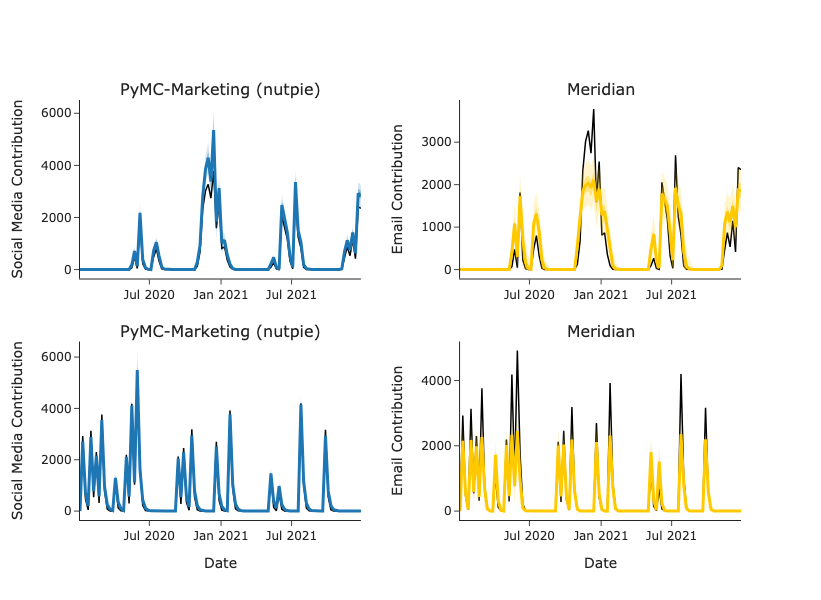

In [235]:
# Colors
pymc_blue = 'rgb(31,119,180)'
google_yellow = 'rgb(255,202,0)'

# Define channels
channels = ['Social-Media', 'Email']
truth_cols = ['contribution_x2_Social-Media', 'contribution_x4_Email']
pymc_vars = ['x2_Social-Media', 'x4_Email']  # names in pymc_contributions
meridian_indices = [1, 3]  # assuming channel dim is 0: 0=Social-Media, 1=Local Ads

dates = pd.to_datetime(truth['time'])

# ------------------ Figure Setup ------------------
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=["PyMC-Marketing (nutpie)", "Meridian"]*2,
    shared_xaxes=False, shared_yaxes=False,
    vertical_spacing=0.15, horizontal_spacing=0.15
)

for row, channel in enumerate(channels):
    # ------------------ PyMC-Marketing (Left) ------------------
    y_pred = pymc_contributions.sel(channel=pymc_vars[row])
    sample_dims = ['chain','draw']

    median_pred = y_pred.median(dim=sample_dims)
    hdi_94 = az.hdi(y_pred, hdi_prob=0.94)
    hdi_50 = az.hdi(y_pred, hdi_prob=0.5)

    median_vals = median_pred.to_numpy()
    hdi_94_lower = hdi_94['channel_contribution_original_scale'].sel(hdi='lower').to_numpy()
    hdi_94_upper = hdi_94['channel_contribution_original_scale'].sel(hdi='higher').to_numpy()
    hdi_50_lower = hdi_50['channel_contribution_original_scale'].sel(hdi='lower').to_numpy()
    hdi_50_upper = hdi_50['channel_contribution_original_scale'].sel(hdi='higher').to_numpy()

    # Actual
    fig.add_trace(go.Scatter(
        x=dates, y=truth[truth_cols[row]].values,
        mode='lines', line=dict(color='black', width=1.5),
        name='Actual' if row==0 else None, showlegend=False
    ), row=row+1, col=1)

    # Median
    fig.add_trace(go.Scatter(
        x=dates, y=median_vals,
        mode='lines', line=dict(color=pymc_blue, width=3),
        name='PyMC-Marketing Median' if row==0 else None,
        showlegend=False
    ), row=row+1, col=1)

    # HDI 94%
    fig.add_trace(go.Scatter(
        x=dates, y=hdi_94_lower, mode='lines', line=dict(width=0), showlegend=False
    ), row=row+1, col=1)
    fig.add_trace(go.Scatter(
        x=dates, y=hdi_94_upper, mode='lines', fill='tonexty',
        fillcolor='rgba(31,119,180,0.2)', line=dict(width=0), showlegend=False
    ), row=row+1, col=1)

    # HDI 50%
    fig.add_trace(go.Scatter(
        x=dates, y=hdi_50_lower, mode='lines', line=dict(width=0), showlegend=False
    ), row=row+1, col=1)
    fig.add_trace(go.Scatter(
        x=dates, y=hdi_50_upper, mode='lines', fill='tonexty',
        fillcolor='rgba(31,119,180,0.4)', line=dict(width=0), showlegend=False
    ), row=row+1, col=1)

    # ------------------ Meridian (Right) ------------------
    geo_predictions = meridian_contributions.sel(channel=meridian_indices[row]).values  # shape: chain x draw x time
    median_pred_meridian = np.median(geo_predictions, axis=(0,1))
    hdi_94_meridian = np.array([az.hdi(geo_predictions[:, :, t].flatten(), hdi_prob=0.94) for t in range(len(dates))])
    hdi_50_meridian = np.array([az.hdi(geo_predictions[:, :, t].flatten(), hdi_prob=0.50) for t in range(len(dates))])

    # Actual
    fig.add_trace(go.Scatter(
        x=dates, y=truth[truth_cols[row]].values,
        mode='lines', line=dict(color='black', width=1.5),
        name='Actual' if row==0 else None, showlegend=False
    ), row=row+1, col=2)

    # Median
    fig.add_trace(go.Scatter(
        x=dates, y=median_pred_meridian,
        mode='lines', line=dict(color=google_yellow, width=3),
        name='Meridian Median' if row==0 else None,
        showlegend=False
    ), row=row+1, col=2)

    # HDI 94%
    fig.add_trace(go.Scatter(
        x=dates, y=hdi_94_meridian[:,0], mode='lines', line=dict(width=0), showlegend=False
    ), row=row+1, col=2)
    fig.add_trace(go.Scatter(
        x=dates, y=hdi_94_meridian[:,1], mode='lines', fill='tonexty',
        fillcolor='rgba(255,202,0,0.2)', line=dict(width=0), showlegend=False
    ), row=row+1, col=2)

    # HDI 50%
    fig.add_trace(go.Scatter(
        x=dates, y=hdi_50_meridian[:,0], mode='lines', line=dict(width=0), showlegend=False
    ), row=row+1, col=2)
    fig.add_trace(go.Scatter(
        x=dates, y=hdi_50_meridian[:,1], mode='lines', fill='tonexty',
        fillcolor='rgba(255,202,0,0.4)', line=dict(width=0), showlegend=False
    ), row=row+1, col=2)

# ------------------ Layout ------------------
fig.update_layout(
    height=600,
    width=1200,
    template='simple_white',
    legend=dict(
        x=1.05,
        y=1,
        traceorder='normal',   # <-- normal order
        bgcolor="rgba(255,255,255,0.5)"
    )
)

# Axis labels
fig.update_xaxes(title_text="Date", row=2, col=1)
fig.update_xaxes(title_text="Date", row=2, col=2)
fig.update_yaxes(title_text="Social Media Contribution", row=1, col=1)
fig.update_yaxes(title_text="Social Media Contribution", row=2, col=1)
fig.update_yaxes(title_text="Email Contribution", row=1, col=2)
fig.update_yaxes(title_text="Email Contribution", row=2, col=2)

fig.show()

# Save figure as HTML
fig.write_html("channel_contribution.html")
